# Coursework: Age regression from brain MRI

Predicting the age of patient from a brain MRI scan can have diagnostic value for a number of diseases that may cause structural changes and potential damage to the brain. A discrepancy between the predicted age and the real, chronological age of a patient might indicate the presence of disease. This requires an accurate predictor of brain age which may be learned from a set of healthy reference subjects, given their brain MRI data and their actual age.

The objective for the coursework is to implement different supervised learning approaches for age regression from brain MRI. We provided data from a total of 652 healthy subjects, that is split into different development sets and a held-out test set on which you will evaluate your final prediction accuracy.

Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are three dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

You may find some useful ideas and implementations in the tutorial notebooks. Once you have implemented all approaches and obtained results from your experiments, we ask you to write a short summary report. The reports should contain a short introduction, description of each of your methods and the individual processing steps, your results with a brief discussion. The report should also include some figures and plots to support your findings.

#### Read the text descriptions and the provided code cells carefully and look out for the cells marked with 'TASK' and 'ADD YOUR CODE HERE'.

### Getting started and familiarise ourselves with the data

The following cells provide some helper functions to load the data, and provide some overview and visualisation of the statistics over the total population of 652 subjects. The data will be split into different subsets to be used for different parts of the coursework. There is a set of 52 subjects to be used in part A to develop an image segmentation method (47 for training, 5 for validation). We then use 500 subjects for training and cross-validation of age regression approaches in part A, B and C. A remaining set of 100 subjects is used to test the final age prediction accuracy and will be made available towards the end of the coursework.

### Running on Colab or Azure

In [0]:
import os
! pip install SimpleITK==1.2.2 
if not os.path.exists('./brainage-data.zip'):
  ! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
  ! unzip brainage-data.zip

# data directory
data_dir = 'data/brain_age/'

### Running on DoC lab machines

In [0]:
# data directory
# data_dir = '/vol/lab/course/416/data/brain_age/'

Let's start by loading the meta data of the entire population, that is the data containing information about the subject IDs, their age, and gender.

In [0]:
import pandas as pd
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import SimpleITK as sitk
from ipywidgets import interact, fixed
from IPython.display import display
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, BayesianRidge, LassoLars
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold

In [0]:
# Read the meta data using pandas
meta_data_all = pd.read_csv(data_dir + 'meta/meta_data_all.csv')
meta_data_all.head() # show the first five data entries

,subject_id,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


In [0]:
if not os.path.exists('iml/meta_data_reg_test.csv'):
  !git clone https://gitlab.doc.ic.ac.uk/hx819/iml.git
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
meta_data_reg_test = pd.read_csv('iml/meta_data_reg_test.csv')

Let's have a look at some population statistics.

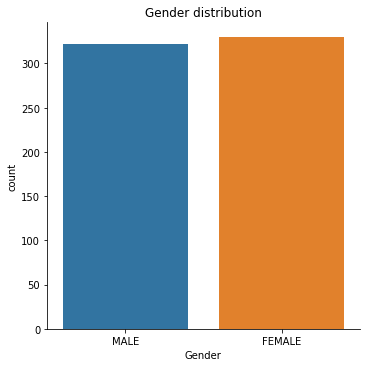

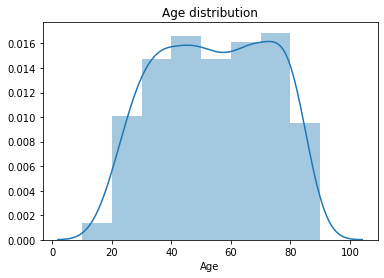

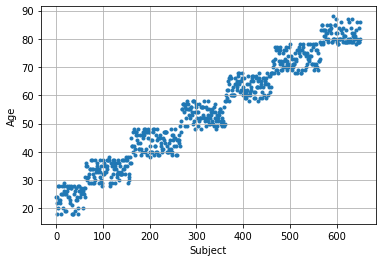

In [0]:
meta_data = meta_data_all

sns.catplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.distplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

### Set up a simple medical image viewer and import SimpleITK

In [0]:
# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray', crosshair=False):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap=colormap, clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap=colormap, clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap=colormap, clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    if crosshair:
        ax1.axhline(y * spacing[1], lw=1)
        ax1.axvline(x * spacing[0], lw=1)
        ax2.axhline(z * spacing[2], lw=1)
        ax2.axvline(x * spacing[0], lw=1)
        ax3.axhline(z * spacing[2], lw=1)
        ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

Imaging data of subject CC110033 with age 24

MR Image (used in part A)


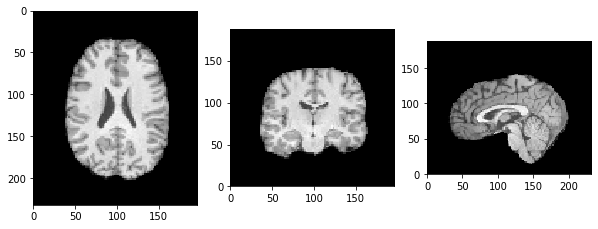

Brain mask (used in part A)


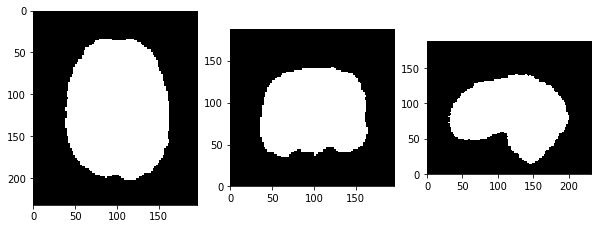

Spatially normalised grey matter maps (used in part B and C)


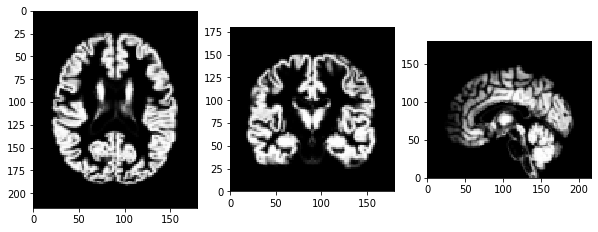

In [0]:
# Subject with index 0
ID = meta_data['subject_id'][0]
age = meta_data['age'][0]

# Image
image_filename = data_dir + 'images/sub-' + ID + '_T1w_unbiased.nii.gz'
img = sitk.ReadImage(image_filename)

# Mask
mask_filename = data_dir + 'masks/sub-' + ID + '_T1w_brain_mask.nii.gz'
msk = sitk.ReadImage(mask_filename)

# Grey matter map

gm_filename = data_dir + 'greymatter/wc1sub-' + ID + '_T1w.nii.gz'
gm = sitk.ReadImage(gm_filename)
print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image (used in part A)')
display_image(img, window=400, level=200)

print('Brain mask (used in part A)')
display_image(msk)

print('Spatially normalised grey matter maps (used in part B and C)')
display_image(gm)

## Part A: Volume-based regression using brain structure segmentation

The first approach aims to regress the age of a subject using the volumes of brain tissues as features. The brain structures include grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume may decrease over time. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a four-class (GM, WM, CSF, and background) brain segmentation needs to be implemented which will be trained using a total of 52 subjects (47 for training, 5 for validation). The segmentation method is then applied to the remaining 600 brain scans which will be used to train and test the age regression. Brain masks are provided which have been generated with a state-of-the-art neuroimaging brain extraction tool.

Different regression techniques should be explored, and it might be beneficial to investigate what the best set of features is for this task. Are all volume features equally useful, or is it even better to combine some of them and create new features. How does a simple linear regression perform compared to a model with higher order polynomials? Do you need regularisation? How about other regression methods such as regression trees, SVMs or neural networks? The accuracy of different methods should be evaluated using two-fold cross-validation on the set of 500 subjects, and average age prediction accuracy should be compared and reported appropriately. The final prediction accuracy will be evaluated on a hold-out set of 100 subjects.

*Note:* For part A, only the MR images and the brain masks should be used from the imaging data. The spatially normalised grey matter maps are used in part B and C only. If you struggle with task A-1, you can continue with A-2 using the provided reference segmentations in subfolder `segs_refs`.

### TASK A-1: Brain tissue segmentation

Implement a CNN model for brain tissue segmentation which can provide segmentations of GM, WM, and CSF. For this task (and only for this task), we provide a subset of 52 subjects which are split into 47 images for training and 5 for validation. The template code below has the data handling and main training routines already implemented, so you can focus on implementing a suitable CNN model. A simple model is provided, but this won't perform very well.

Once your model is trained and you are happy with the results on the validation data you should apply it to the 500 subjects later used for training the age regressor. We provide reference segmentations in a subfolder `segs_refs` for all subjects. Calculate Dice similarity coefficients per tissue when comparing your predicted segmentations to the reference segmentations. Summarise the statistics of the 500 Dice scores for each tissue class in [box-and-whisker-plots](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.boxplot.html).

*Note:* Implementing a full-fledged machine learning pipeline with training and testing procedures in Jupyter notebooks is a bit cumbersome and a pain to debug. Also, running bigger training tasks can be unstable. The code below should work as is on your VM. However, if you want to get a bit more serious about implementing an advanced CNN approach for image segmentation, you may want to move code into separate Python scripts and run these from the terminal.

#### Data Helpers

In [0]:
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, file_list_seg, file_list_msk, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)

        return {'img': image, 'seg': seg, 'msk': msk}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]


#### Check that the GPU is up and running

In [0]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))    

!nvidia-smi    

Device: cuda:0
GPU: Tesla P100-PCIE-16GB
Mon Mar  2 19:14:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    41W / 250W |  10895MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                   

#### Config and hyper-parameters

Here we set some default hyper-parameters and a starting configuration for the image resolution and others.

**TASK: This needs to be revisited to optimise these values. In particular, you may want to run your final model on higher resolution images.**

In [0]:
rnd_seed = 42 #fixed random seed
torch.manual_seed(rnd_seed)
img_size = [64, 64, 64]
img_spacing = [3, 3, 3]

num_epochs = 100
learning_rate = 0.01
batch_size = 8
val_interval = 10

num_classes = 4

out_dir = './output'
loss_history = []
test_mae_history = []
# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

#### Loading and pre-processing of training and validation data

In [0]:
meta_data_seg_train = pd.read_csv(data_dir + 'meta/meta_data_seg_train.csv')
ids_seg_train = list(meta_data_seg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_seg_val = pd.read_csv(data_dir + 'meta/meta_data_seg_val.csv')
ids_seg_val = list(meta_data_seg_val['subject_id'])
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

We apply some standard pre-processing on the data such as intensity normalization (zero mean unit variance) and downsampling according to the configuration above.

**You may want to use initially the validation data with 5 subjects for training which is more efficient when debugging your training routine and model implementation. Make sure to later train your final model on the actual training data.**

In [0]:
# LOAD ACTUAL TRAINING DATA
dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
# LOAD VALIDATION DATA AS TRAINING FOR QUICK DEBUGGING
# dataset_train = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 5/5 [00:00<00:00,  7.03it/s]


#### Visualise training example

Just to check how a training image looks like after pre-processing.

Image: sub-CC221040_T1w_unbiased.nii.gz


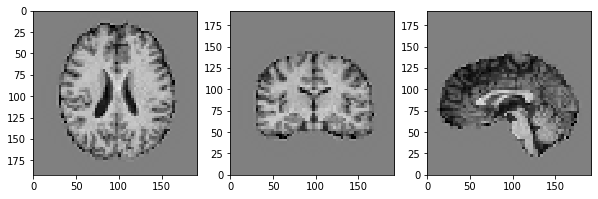

Segmentation


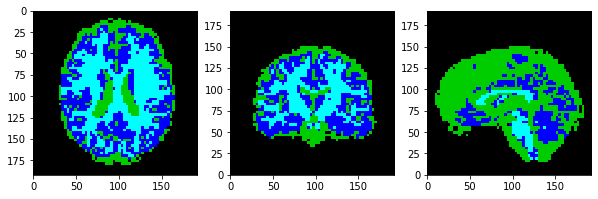

Mask


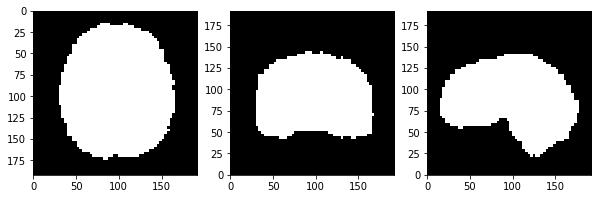

In [0]:
sample = dataset_train.get_sample(0)
img_name = dataset_train.get_img_name(0)
seg_name = dataset_train.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### The Model

**TASK:** This is the **key part of task A-1** where you have to design a suitable CNN model for brain segmentation. The simple model provided below works to some degree (it let's you run through the upcoming cells), but it will not perform very well. Use what you learned in the lectures to come up with a good architecture. Start with a simple, shallow model and only increase complexity (e.g., number of layers) if needed.

In [0]:
########################################
# BUILD A BETTER MODEL HERE
########################################

class SimpleNet3D(nn.Module):

    def __init__(self, num_classes):
        super(SimpleNet3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(4, 8, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(8, 4, kernel_size=3, padding=1)
        self.conv4 = nn.Conv3d(4, num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        return F.softmax(x, dim=1)

In [0]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """2 layers of convolution which have same out channels"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up = nn.ConvTranspose3d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])
        diffZ = torch.tensor([x2.size()[4] - x1.size()[4]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [0]:
""" Full assembly of the parts to form the complete network """

import torch.nn.functional as F


class Modified3DUNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(Modified3DUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

#### TRAINING

Below is an implementation of a full training procedure including a loop for intermediate evaluation of the model on the validation data. Feel free to modify this procedure. For example, in addition to the loss you may want to monitor precision, recall and Dice scores (or others).

In [0]:
torch.cuda.empty_cache()
!nvidia-smi

Mon Mar  2 19:14:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    47W / 250W |   1725MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 0.451625
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 0.399202


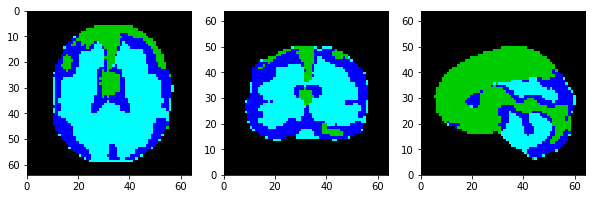

--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 0.295317
+ TRAINING 	Epoch: 3 	Loss: 0.239872
+ TRAINING 	Epoch: 4 	Loss: 0.232796
+ TRAINING 	Epoch: 5 	Loss: 0.211434
+ TRAINING 	Epoch: 6 	Loss: 0.191330
+ TRAINING 	Epoch: 7 	Loss: 0.179337
+ TRAINING 	Epoch: 8 	Loss: 0.179132
+ TRAINING 	Epoch: 9 	Loss: 0.175473
+ TRAINING 	Epoch: 10 	Loss: 0.172925
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 0.172483


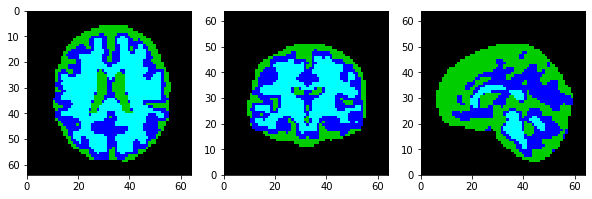

--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 0.154912
+ TRAINING 	Epoch: 12 	Loss: 0.158125
+ TRAINING 	Epoch: 13 	Loss: 0.158004
+ TRAINING 	Epoch: 14 	Loss: 0.138001
+ TRAINING 	Epoch: 15 	Loss: 0.149570
+ TRAINING 	Epoch: 16 	Loss: 0.150081
+ TRAINING 	Epoch: 17 	Loss: 0.133991
+ TRAINING 	Epoch: 18 	Loss: 0.133032
+ TRAINING 	Epoch: 19 	Loss: 0.138035
+ TRAINING 	Epoch: 20 	Loss: 0.125132
--------------------------------------------------
+ VALIDATE 	Epoch: 20 	Loss: 0.128729


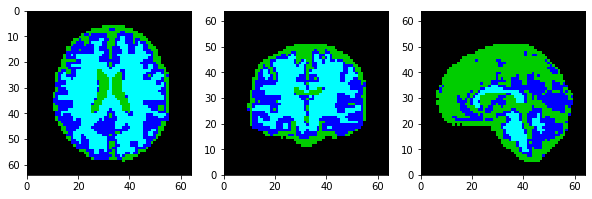

--------------------------------------------------
+ TRAINING 	Epoch: 21 	Loss: 0.118629
+ TRAINING 	Epoch: 22 	Loss: 0.117757
+ TRAINING 	Epoch: 23 	Loss: 0.122342
+ TRAINING 	Epoch: 24 	Loss: 0.108935
+ TRAINING 	Epoch: 25 	Loss: 0.109593
+ TRAINING 	Epoch: 26 	Loss: 0.128519
+ TRAINING 	Epoch: 27 	Loss: 0.120389
+ TRAINING 	Epoch: 28 	Loss: 0.126116
+ TRAINING 	Epoch: 29 	Loss: 0.107001
+ TRAINING 	Epoch: 30 	Loss: 0.100251
--------------------------------------------------
+ VALIDATE 	Epoch: 30 	Loss: 0.108821


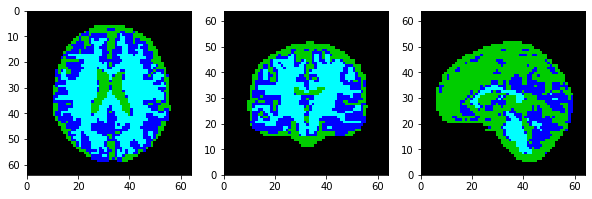

--------------------------------------------------
+ TRAINING 	Epoch: 31 	Loss: 0.109056
+ TRAINING 	Epoch: 32 	Loss: 0.093730
+ TRAINING 	Epoch: 33 	Loss: 0.104372
+ TRAINING 	Epoch: 34 	Loss: 0.111044
+ TRAINING 	Epoch: 35 	Loss: 0.096774
+ TRAINING 	Epoch: 36 	Loss: 0.095500
+ TRAINING 	Epoch: 37 	Loss: 0.093691
+ TRAINING 	Epoch: 38 	Loss: 0.094187
+ TRAINING 	Epoch: 39 	Loss: 0.090756
+ TRAINING 	Epoch: 40 	Loss: 0.090956
--------------------------------------------------
+ VALIDATE 	Epoch: 40 	Loss: 0.093656


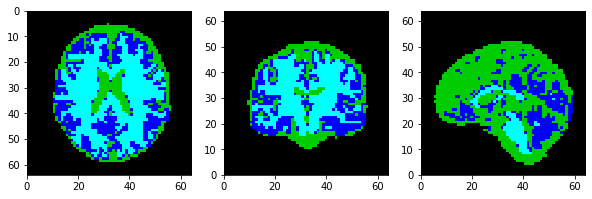

--------------------------------------------------
+ TRAINING 	Epoch: 41 	Loss: 0.094813
+ TRAINING 	Epoch: 42 	Loss: 0.082850
+ TRAINING 	Epoch: 43 	Loss: 0.094193
+ TRAINING 	Epoch: 44 	Loss: 0.090956
+ TRAINING 	Epoch: 45 	Loss: 0.081747
+ TRAINING 	Epoch: 46 	Loss: 0.084823
+ TRAINING 	Epoch: 47 	Loss: 0.095969
+ TRAINING 	Epoch: 48 	Loss: 0.079677
+ TRAINING 	Epoch: 49 	Loss: 0.079660
+ TRAINING 	Epoch: 50 	Loss: 0.083905
--------------------------------------------------
+ VALIDATE 	Epoch: 50 	Loss: 0.092649


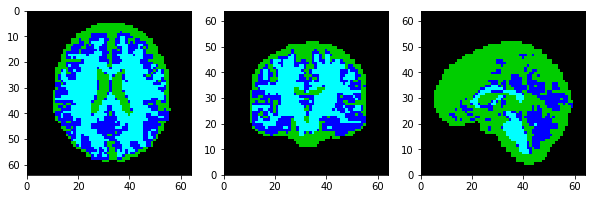

--------------------------------------------------
+ TRAINING 	Epoch: 51 	Loss: 0.076278
+ TRAINING 	Epoch: 52 	Loss: 0.086779
+ TRAINING 	Epoch: 53 	Loss: 0.081900
+ TRAINING 	Epoch: 54 	Loss: 0.075486
+ TRAINING 	Epoch: 55 	Loss: 0.080958
+ TRAINING 	Epoch: 56 	Loss: 0.072766
+ TRAINING 	Epoch: 57 	Loss: 0.074765
+ TRAINING 	Epoch: 58 	Loss: 0.082990
+ TRAINING 	Epoch: 59 	Loss: 0.077171
+ TRAINING 	Epoch: 60 	Loss: 0.074866
--------------------------------------------------
+ VALIDATE 	Epoch: 60 	Loss: 0.081375


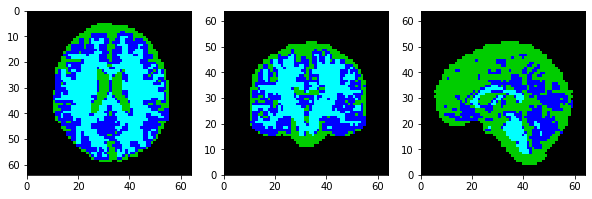

--------------------------------------------------
+ TRAINING 	Epoch: 61 	Loss: 0.074587
+ TRAINING 	Epoch: 62 	Loss: 0.070878
+ TRAINING 	Epoch: 63 	Loss: 0.078925
+ TRAINING 	Epoch: 64 	Loss: 0.076038
+ TRAINING 	Epoch: 65 	Loss: 0.073099
+ TRAINING 	Epoch: 66 	Loss: 0.072408
+ TRAINING 	Epoch: 67 	Loss: 0.074760
+ TRAINING 	Epoch: 68 	Loss: 0.082611
+ TRAINING 	Epoch: 69 	Loss: 0.074367
+ TRAINING 	Epoch: 70 	Loss: 0.075368
--------------------------------------------------
+ VALIDATE 	Epoch: 70 	Loss: 0.079806


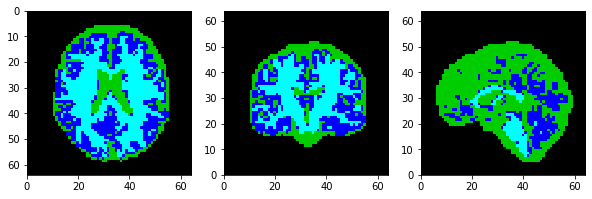

--------------------------------------------------
+ TRAINING 	Epoch: 71 	Loss: 0.072907
+ TRAINING 	Epoch: 72 	Loss: 0.071682
+ TRAINING 	Epoch: 73 	Loss: 0.072490
+ TRAINING 	Epoch: 74 	Loss: 0.075547
+ TRAINING 	Epoch: 75 	Loss: 0.069599
+ TRAINING 	Epoch: 76 	Loss: 0.077431
+ TRAINING 	Epoch: 77 	Loss: 0.067941
+ TRAINING 	Epoch: 78 	Loss: 0.070768
+ TRAINING 	Epoch: 79 	Loss: 0.070111
+ TRAINING 	Epoch: 80 	Loss: 0.066806
--------------------------------------------------
+ VALIDATE 	Epoch: 80 	Loss: 0.074151


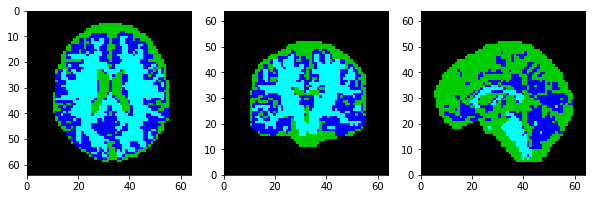

--------------------------------------------------
+ TRAINING 	Epoch: 81 	Loss: 0.077486
+ TRAINING 	Epoch: 82 	Loss: 0.070528
+ TRAINING 	Epoch: 83 	Loss: 0.068398
+ TRAINING 	Epoch: 84 	Loss: 0.066021
+ TRAINING 	Epoch: 85 	Loss: 0.071697
+ TRAINING 	Epoch: 86 	Loss: 0.064167
+ TRAINING 	Epoch: 87 	Loss: 0.070691
+ TRAINING 	Epoch: 88 	Loss: 0.068406
+ TRAINING 	Epoch: 89 	Loss: 0.070003
+ TRAINING 	Epoch: 90 	Loss: 0.075547
--------------------------------------------------
+ VALIDATE 	Epoch: 90 	Loss: 0.073570


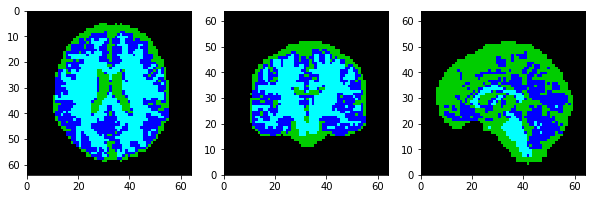

--------------------------------------------------
+ TRAINING 	Epoch: 91 	Loss: 0.063840
+ TRAINING 	Epoch: 92 	Loss: 0.064565
+ TRAINING 	Epoch: 93 	Loss: 0.067842
+ TRAINING 	Epoch: 94 	Loss: 0.065993
+ TRAINING 	Epoch: 95 	Loss: 0.065152
+ TRAINING 	Epoch: 96 	Loss: 0.061983
+ TRAINING 	Epoch: 97 	Loss: 0.068783
+ TRAINING 	Epoch: 98 	Loss: 0.062399
+ TRAINING 	Epoch: 99 	Loss: 0.066299
+ TRAINING 	Epoch: 100 	Loss: 0.062231
--------------------------------------------------
+ VALIDATE 	Epoch: 100 	Loss: 0.072282


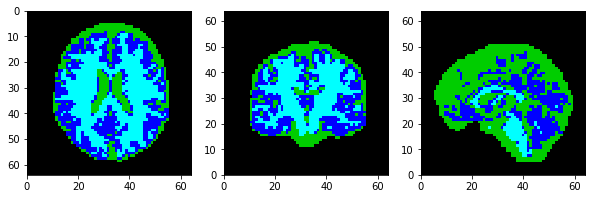

--------------------------------------------------

Finished TRAINING.


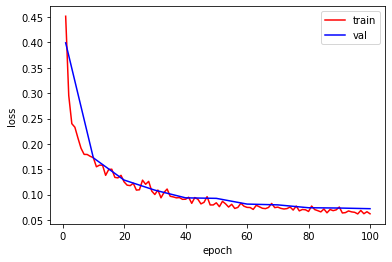

In [0]:
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

# model = SimpleNet3D(num_classes=num_classes).to(device)
model = Modified3DUNet(1, num_classes).to(device)
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train_log = []
loss_val_log = []
epoch_val_log = []
    
print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss = F.cross_entropy(prd_flat, seg_flat.squeeze(1))
        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    
    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        with torch.no_grad():
            for data_sample in dataloader_val:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd = model(img)
                prd_flat = prd.view(prd.size(0), prd.size(1), -1)
                seg_flat = seg.view(seg.size(0), seg.size(1), -1)
                loss_val += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
                sum_pts += seg_flat.size(2)
                
        prd = torch.argmax(prd, dim=1)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        

        loss_val /= sum_pts

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)

        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
        display_image(sitk.LabelToRGB(prediction))
        print('--------------------------------------------------')

torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

print('\nFinished TRAINING.')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Loading and pre-processing of testing data

Now that we have trained a model, the next cells are about applying that model to the 500 subjects that are used for training the age regressor. Note, at a later stage you will also need to run the model on the 100 subjects from the hold-out set, once these have been made available. Before testing on the full set, you may want to initially just test on the 5 validation subjects to check everything is working fine.

In [0]:
ids_seg_train = list(meta_data_reg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 500/500 [01:10<00:00,  7.44it/s]


In [0]:
ids_seg_test = list(meta_data_reg_test['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 100/100 [00:13<00:00,  7.42it/s]


#### Visualise testing example

Just to check how a testing image looks like after pre-processing.

Image: sub-CC321594_T1w_unbiased.nii.gz


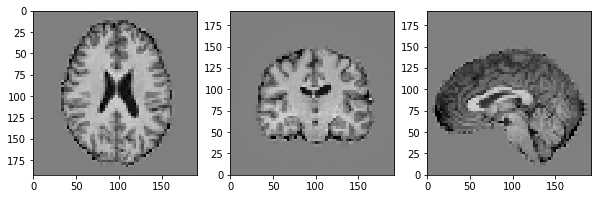

Segmentation


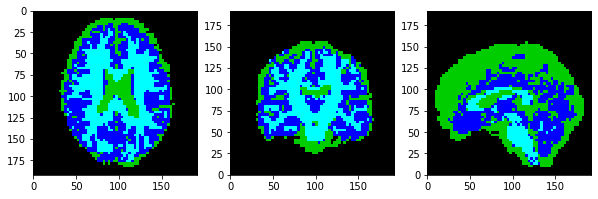

Mask


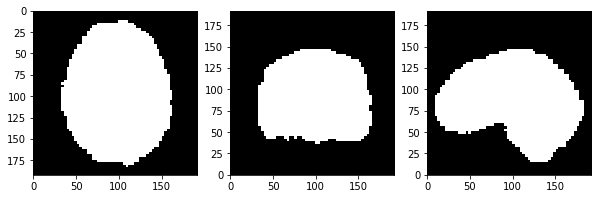

In [0]:
sample = dataset_test.get_sample(0)
img_name = dataset_test.get_img_name(0)
seg_name = dataset_test.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### TESTING

Below is an implementation of a full testing procedure that saves the segmentations in an output folder. Feel free to modify this procedure.

**TASK: You will need to add the calculations of Dice scores (and possibly others) to evaluate the segmentation performance.**

START PREDICTING TRAIN IMAGES...
+ TRAIN IMAGE 	Loss: 0.075862
DSC	0.8934842655694271


Reference segmentation


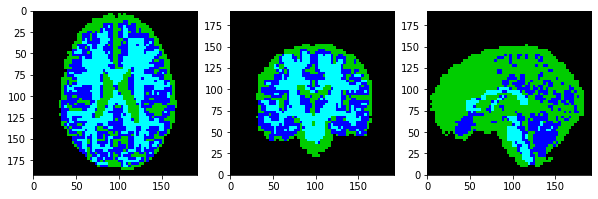

Predicted segmentation


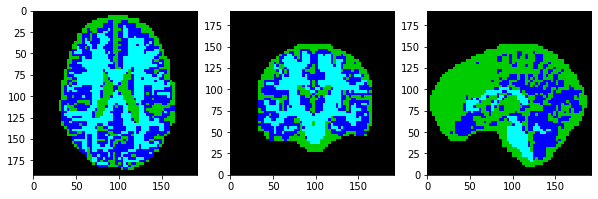


Finished TRAIN IMAGES.


In [0]:
pred_dir = os.path.join(out_dir, 'pred/')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = Modified3DUNet(1, num_classes).to(device)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
print('START PREDICTING TRAIN IMAGES...')

loss_test = 0
sum_pts = 0
idx_test = 0
d_score = 0 #Dice scores
with torch.no_grad():
    for data_sample in dataloader_train:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss_test += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
        sum_pts += seg_flat.size(2)        
        
        prd = torch.argmax(prd, dim=1)

        sample = dataset_train.get_sample(idx_test)
        name = dataset_train.get_seg_name(idx_test)
        #get prediction
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])

        #get original
        segmentation = sitk.GetImageFromArray(seg.cpu().squeeze().numpy().astype(np.uint8))
        segmentation.CopyInformation(sample['seg'])
        #calculate Dice scores
        overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
        overlap_measures_filter.Execute(prediction, segmentation)
        d_score += overlap_measures_filter.GetDiceCoefficient()

        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        
        idx_test += 1
        
loss_test /= sum_pts
avg_d_score = d_score / idx_test
print('+ TRAIN IMAGE \tLoss: {:.6f}'.format(loss_test))
print('DSC\t' + str(avg_d_score))
# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TRAIN IMAGES.')

START TESTING...
+ TESTING 	Loss: 0.071224
DSC	0.8942547258036556


Reference segmentation


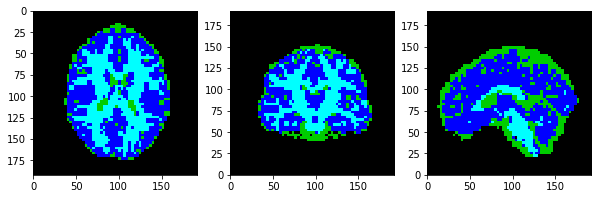

Predicted segmentation


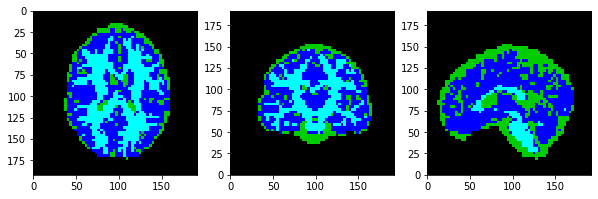


Finished TESTING.


In [0]:
pred_dir = os.path.join(out_dir, 'pred/')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = Modified3DUNet(1, num_classes).to(device)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
print('START TESTING...')

loss_test = 0
sum_pts = 0
idx_test = 0
d_score = 0 #Dice scores
with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss_test += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
        sum_pts += seg_flat.size(2)        
        
        prd = torch.argmax(prd, dim=1)

        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        #get prediction
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])

        #get original
        segmentation = sitk.GetImageFromArray(seg.cpu().squeeze().numpy().astype(np.uint8))
        segmentation.CopyInformation(sample['seg'])
        #calculate Dice scores
        overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
        overlap_measures_filter.Execute(prediction, segmentation)
        d_score += overlap_measures_filter.GetDiceCoefficient()

        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        
        idx_test += 1
        
loss_test /= sum_pts
avg_d_score = d_score / idx_test
print('+ TESTING \tLoss: {:.6f}'.format(loss_test))
print('DSC\t' + str(avg_d_score))
# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

### TASK A-2: Feature calculation

Start by calculating the three absolute tissue volumes for each subject. Plot the volumes against the subjects' ages. Taking the absolute volumes of tissues as features, however, might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. But you might also want to explore using different combinations or even polynomial features.

Implement a function that constructs a big matrix $X$ with a row for each subject and features across the columns. Start with just calculating three simple features of relative tissue volumes for GM, WM and CSF, and compare these to the absolute volumes plotted above.

*Note:* If you are struggling with the previous task on image segmentation, or if you prefer to work on this and the following tasks first, you can continue here using the provided reference segmentations which can be found in a subfolder `segs_refs`.

In [0]:
seg_dir = data_dir + 'segs_refs/'
# seg_dir = pred_dir

ids_reg_train = list(meta_data_reg_train['subject_id'])
ids_reg_test = list(meta_data_reg_test['subject_id'])

files_reg_seg_train = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_train]
files_reg_seg_test = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_test]

y_data_train = meta_data_reg_train['age'].values.reshape(-1,1)
y_data_test = meta_data_reg_test['age'].values.reshape(-1,1)

In [0]:
## CALCULATE ABSOLUTE TISSUE VOLUMES


# USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
#seg_dir = './output/pred/'

# USE THIS TO RUN THE CALCULATIONS ON OUR REFERENCE SEGMENTATIONS


# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
vols = np.zeros((len(files_reg_seg_train), 3))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_train[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        
        ########################################
        # ADD YOUR CODE HERE
        ########################################
        seg_array = sitk.GetArrayFromImage(seg)
        
        # 0: background, 1: CSF, 2: GM, 3: WM
        cs = np.sum(seg_array == 1)
        gm = np.sum(seg_array == 2)
        wm = np.sum(seg_array == 3)
        
        vols[idx, 0] = cs
        vols[idx, 1] = gm
        vols[idx, 2] = wm

Calculating Features: 100%|██████████| 500/500 [00:03<00:00, 133.86it/s]


Plot features versus age.

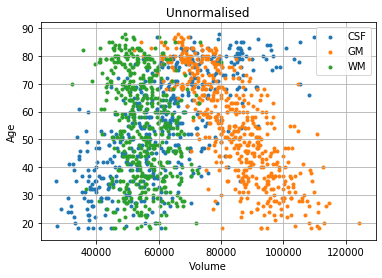

In [0]:
plt.scatter(vols[:, 0], meta_data_reg_train['age'], marker='.')
plt.scatter(vols[:, 1], meta_data_reg_train['age'], marker='.')
plt.scatter(vols[:, 2], meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Unnormalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

In [0]:
seg_data_train = np.zeros((len(files_reg_seg_train), 3))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_train[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        
        ########################################
        # ADD YOUR CODE HERE
        ########################################
        seg_array = sitk.GetArrayFromImage(seg)
        
        # 0: background, 1: CSF, 2: GM, 3: WM
        oa = len(seg_array.flatten())
        bg = np.sum(seg_array == 0)
        cs = np.sum(seg_array == 1)
        gm = np.sum(seg_array == 2)
        wm = np.sum(seg_array == 3)
        
        # Calculate relative volume
        seg_data_train[idx, 0] = cs/(oa-bg)
        seg_data_train[idx, 1] = gm/(oa-bg)
        seg_data_train[idx, 2] = wm/(oa-bg)

seg_data_test = np.zeros((len(files_reg_seg_test), 3))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_test)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_test[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        
        ########################################
        # ADD YOUR CODE HERE
        ########################################
        seg_array = sitk.GetArrayFromImage(seg)
        
        # 0: background, 1: CSF, 2: GM, 3: WM
        oa = len(seg_array.flatten())
        bg = np.sum(seg_array == 0)
        cs = np.sum(seg_array == 1)
        gm = np.sum(seg_array == 2)
        wm = np.sum(seg_array == 3)
        
        # Calculate relative volume
        seg_data_test[idx, 0] = cs/(oa-bg)
        seg_data_test[idx, 1] = gm/(oa-bg)
        seg_data_test[idx, 2] = wm/(oa-bg)

print()
print(np.shape(seg_data_train))
print(np.shape(seg_data_test))

Calculating Features: 100%|██████████| 100/100 [00:00<00:00, 114.54it/s]


(500, 3)
(100, 3)


Plot normalised features versus age.

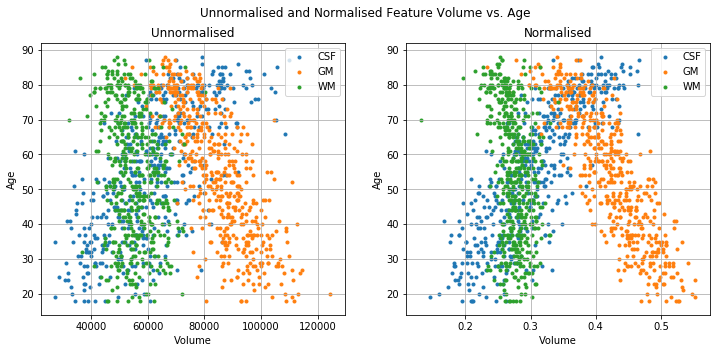

In [0]:
fig = plt.figure(figsize=(12, 5))
fig.suptitle('Unnormalised and Normalised Feature Volume vs. Age')
plt.subplot(1, 2, 1)
plt.scatter(vols[:, 0], meta_data_reg_train['age'], marker='.')
plt.scatter(vols[:, 1], meta_data_reg_train['age'], marker='.')
plt.scatter(vols[:, 2], meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Unnormalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))

plt.subplot(1, 2, 2)
plt.scatter(seg_data_train[:, 0], meta_data_reg_train['age'], marker='.')
plt.scatter(seg_data_train[:, 1], meta_data_reg_train['age'], marker='.')
plt.scatter(seg_data_train[:, 2], meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Normalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

Final data for age regression

### TASK A-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Remember to construct the output vectur $y$ containing the age for each of the subjects.

Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) where the dataset of 500 subjects is split into two equally sized sets $(X_1,y_1)$ and $(X_2,y_2)$ which are used for training and testing in an alternating way (so each set is used as $(X_{\text{train}},y_{\text{train}})$ and $(X_{\text{test}},y_{\text{test}})$ exactly once).

Try using at least three different regression methods, and generate a plot allows easy comparison of the performance of the three methods. Useful [error metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) to report include mean absolute error and r2 score. You might also want to plot the real vs predicted ages.

*Note:* These [scikit-learn examples](https://scikit-learn.org/stable/auto_examples/) might serve as an inspiration.

*Hint:* Be careful how you split the dataset into two folds. Take into account the data characteristics shown at the top of the notebook.

In [0]:
def display_pred(preds, y, info=None):
    preds = np.asarray(preds)

    height = np.max([np.max(preds), np.max(y)]) * 1.1
    
    if np.ndim(preds) == 3:
      for i in range(len(preds)):
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.scatter(y, preds[i], marker='.')
        ax.plot([np.min(y), np.max(y)], [np.min(y), np.max(y)], 'k--', lw=2)
        ax.set_xbound(0, height)
        ax.set_ybound(0, height)
        ax.set_xlabel('Real Age')
        ax.set_ylabel('Predicted Age')
        if info != None:
            ax.set_title(info[i])
    
    else:
      fig, ax = plt.subplots(figsize=(5, 5))
      ax.scatter(y, preds, marker='.')
      ax.plot([np.min(y), np.max(y)], [np.min(y), np.max(y)], 'k--', lw=2)
      ax.set_xbound(0, height)
      ax.set_ybound(0, height)
      ax.set_xlabel('Real Age')
      ax.set_ylabel('Predicted Age')
      if info != None:
          ax.set_title(info)

    plt.show()

Fold 1
Linear Regression: mae= 8.06 , r2= 0.69
Lasso Regression: mae= 8.15 , r2 = 0.7
K Neighbors Regression: mae= 8.25 , r2 = 0.67
Bayesian Ridge Regression: mae = 8.05 , r2 = 0.7

Fold 2
Linear Regression: mae= 7.62 , r2= 0.74
Lasso Regression: mae= 7.92 , r2 = 0.73
K Neighbors Regression: mae= 8.0 , r2 = 0.71
Bayesian Ridge Regression: mae = 7.62 , r2 = 0.74

Test result:
Linear Regression: mae = 7.2 , r2 = 0.78
Lasso Regression: mae = 7.54 , r2 = 0.76
K Neighbors Regression: mae = 7.52 , r2 = 0.73
Bayesian Ridge Regression: mae = 7.2 , r2 = 0.78


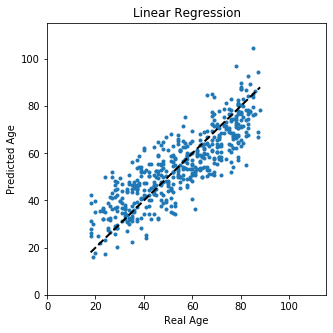

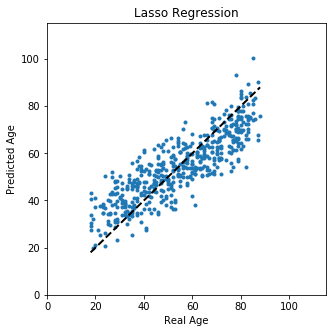

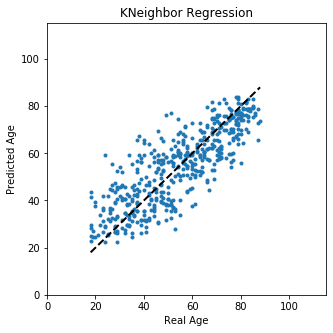

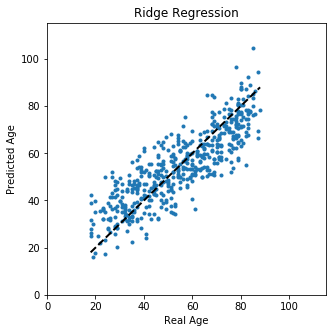

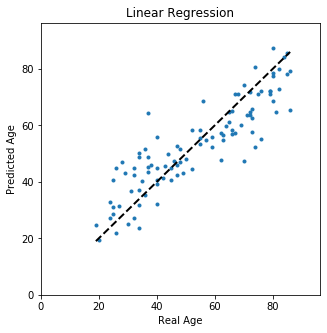

In [0]:
########################################
# ADD YOUR CODE HERE
########################################
k = 2
kf = KFold(n_splits=k, shuffle=True, random_state=rnd_seed)

lr_preds = []
ll_preds = []
knn_preds = []
ridge_preds = []
y_vals = []

lr_test_mae = []
ll_test_mae = []
knn_test_mae = []
ridge_test_mae = []

lr_test_r2 = []
ll_test_r2 = []
knn_test_r2 = []
ridge_test_r2 = []

for i, (train_index, val_index) in enumerate(kf.split(seg_data_train)):
    print('Fold', i + 1)

    # Load data and reshape
    X_train = seg_data_train[train_index].reshape(len(train_index), -1)
    X_val = seg_data_train[val_index].reshape(len(val_index), -1)
    X_test = seg_data_test.reshape(len(seg_data_test), -1)
    y_train = y_data_train[train_index].ravel()
    y_val = y_data_train[val_index].ravel()
    y_vals.append(y_val)
    y_test = y_data_test.ravel()

    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_pred = lr.predict(X_val)
    lr_preds.append(lr_pred)
    lr_mae = np.round(mean_absolute_error(y_val, lr_pred), 2)
    lr_r2 = np.round(r2_score(y_val, lr_pred), 2)
    print('Linear Regression: mae=', lr_mae, ', r2=', lr_r2)
    
    # Lasso Regression
    ll = LassoLars(alpha=0.1)
    ll.fit(X_train, y_train)
    ll_pred = ll.predict(X_val)
    ll_preds.append(ll_pred)
    ll_mae = np.round(mean_absolute_error(y_val, ll_pred), 2)
    ll_r2 = np.round(r2_score(y_val, ll_pred), 2)
    print('Lasso Regression: mae=', ll_mae, ', r2 =', ll_r2)
    
    # KNN Regression
    knn = KNeighborsRegressor(n_neighbors=4, algorithm='auto')
    knn.fit(X_train, y_train)
    knn_pred = knn.predict(X_val)
    knn_preds.append(knn_pred)
    knn_mae = np.round(mean_absolute_error(y_val, knn_pred), 2)
    knn_r2 = np.round(r2_score(y_val, knn_pred), 2)
    print('K Neighbors Regression: mae=', knn_mae, ', r2 =', knn_r2)

    # Bayesian Ridge Regression
    br = BayesianRidge(normalize=True)
    br.fit(X_train, y_train)
    ridge_pred = br.predict(X_val)
    ridge_preds.append(ridge_pred)
    ridge_mae = np.round(mean_absolute_error(y_val, ridge_pred), 2)
    ridge_r2 = np.round(r2_score(y_val, ridge_pred), 2)
    print('Bayesian Ridge Regression: mae =', ridge_mae, ', r2 =', ridge_r2)
    
    # Testing with 100 samples
    lr_test = lr.predict(X_test)
    lr_test_mae.append(mean_absolute_error(y_test, lr_test))
    lr_test_r2.append(r2_score(y_test, lr_test))

    ll_test = ll.predict(X_test)
    ll_test_mae.append(mean_absolute_error(y_test, ll_test))
    ll_test_r2.append(r2_score(y_test, ll_test))

    knn_test = knn.predict(X_test)
    knn_test_mae.append(mean_absolute_error(y_test, knn_test))
    knn_test_r2.append(r2_score(y_test, knn_test))

    ridge_test = br.predict(X_test)
    ridge_test_mae.append(mean_absolute_error(y_test, ridge_test))
    ridge_test_r2.append(r2_score(y_test, ridge_test))

    print()

print('Test result:')

print('Linear Regression: mae =', np.round(np.average(lr_test_mae), 2), 
      ', r2 =', np.round(np.average(lr_test_r2), 2))
print('Lasso Regression: mae =', np.round(np.average(ll_test_mae), 2), 
      ', r2 =', np.round(np.average(ll_test_r2), 2))
print('K Neighbors Regression: mae =', np.round(np.average(knn_test_mae), 2), 
      ', r2 =', np.round(np.average(knn_test_r2), 2))
print('Bayesian Ridge Regression: mae =', np.round(np.average(ridge_test_mae), 2), 
      ', r2 =', np.round(np.average(ridge_test_r2), 2))

display_pred([lr_preds, ll_preds, knn_preds, ridge_preds], y_vals, 
             info=['Linear Regression', 'Lasso Regression', 
                   'KNeighbor Regression', 'Ridge Regression'])

display_pred(lr_test, y_test, info='Linear Regression')

## Part B: PCA-based regression using grey matter maps

The second approach will make use of grey matter maps that have been already extracted from the MRI scans and aligned to a common reference space to obtain spatially normalised maps. For this, we have used an advanced, state-of-the-art neuroimaging toolkit, called SPM12. The reference space corresponds to the commonly used MNI atlas as seen in the lecture on image segmentation.

Because these grey matter maps are spatially normalised (ie., registered), voxel locations across images from different subjects roughly correspond to the same anatomical locations. This means that each voxel location in the grey matter maps can be treated as an individual feature. Because those maps are quite large at their full resolution there would be a very large number of features to deal with (more than 850,000). A dimensionality reduction may need to be performed before training a suitable regressor on the low-dimensional feature representation. We will use Principal Component Analysis (PCA) to do the dimensionality reduction. It might also be beneficial to apply some pre-processing (downsampling, smoothing, etc.) before running PCA, which should be explored. The implemented pipeline should be evaluated using two-fold cross-validation using the same data splits as in part A for the 500 subjects, so the two different approaches can be directly compared in terms average age prediction accuracy.

*Note:* For part B, only the spatially normalised grey matter maps should be used.

### TASK B-1: Pre-processing

Before running PCA to reduce the dimensionality of the feature space for grey matter maps, it might be beneficial to run some pre-processing on the maps. In voxel-based analysis where each voxel location is a feature, it is common to apply some smoothing beforehand. This is to reduce noise and to compensate for errors of the spatial normalisation.

Because the maps are quite large, it might also be worthwile to explore whether downsampling could be performed even before PCA. This would further reduce the dimensionality, and might be even needed in the case where PCA on the orignial resolution runs into memory issues. You may want to consider other ways of pre-processing and you can find insipiration in the notebook on medical image computing `02-Intro-Medical-Image-Computing.ipynb`.

Implement a function that performs suitable pre-processing on each grey matter map.

*Hint:* You may want to save the pre-processed maps using `sitk.WriteImage` to avoid recomputation each time you run the notebook.

In [0]:
def preprocess(img):
  # img_preprocessed = sitk.GradientAnisotropicDiffusion(img)
  img_preprocessed = sitk.DiscreteGaussian(img, 1.0)
  # img = zero_mean_unit_var(img, img)
  return img_preprocessed

In [0]:
def preprocess_grey_matter_map():
  print('Loading and pre-processing training images')
  gm_train_num = len(meta_data_reg_train['subject_id'])
  gm_data_train = []

  for i, subject_id in enumerate(meta_data_reg_train['subject_id']):
    gm_filename = str(data_dir + 'greymatter/wc1sub-' + 
                      subject_id + '_T1w.nii.gz')
    gm = preprocess(sitk.ReadImage(gm_filename))
    gm = resample_image(gm, out_spacing=img_spacing, out_size=img_size)
    gm = sitk.GetArrayFromImage(gm)
    # gm = gm[::2, ::2, ::2]
    gm_data_train.append(gm)

    if i % 100 == 0:
      print('Loaded [', i, '/', gm_train_num, '] images')

  print('Loading and pre-processing testing images')
  gm_test_num = len(meta_data_reg_test['subject_id'])
  gm_data_test = []

  for i, subject_id in enumerate(meta_data_reg_test['subject_id']):
    gm_filename = str(data_dir + 'greymatter/wc1sub-' + 
                      subject_id + '_T1w.nii.gz')
    gm = preprocess(sitk.ReadImage(gm_filename))
    gm = resample_image(gm, out_spacing=img_spacing, out_size=img_size)
    gm = sitk.GetArrayFromImage(gm)
    # gm = gm[::2, ::2, ::2]
    gm_data_test.append(gm)

    if i % 100 == 0:
      print('Loaded [', i, '/', gm_test_num, '] images')

  print('Finished loading')
  return np.asarray(gm_data_train), np.asarray(gm_data_test)

In [0]:
def save_preprocessed_image():
  gm_num = len(meta_data['subject_id'])
  count = 0
  for subject_id in meta_data['subject_id']:
    gm_filename = data_dir + 'greymatter/wc1sub-' + subject_id + '_T1w.nii.gz'
    gm = sitk.ReadImage(gm_filename)
    gm_preprocessed = preprocess(gm)
    sitk.WriteImage(gm_preprocessed, str(data_dir + 'greymatter/wc1sub-' + 
                                      subject_id + '_T1w_preprocessed.nii.gz'))
    if count % 50 == 0:
      print('Processed [', count, '/', gm_num, '] images')
    count += 1

def load_preprocessed_grey_matter_map(resampling=True):
  gm_data_train = []
  gm_data_test = []

  print('Loading training pre-processed images')
  gm_train_num = len(meta_data_reg_train['subject_id'])

  for subject_id in meta_data_reg_train['subject_id']:
    try:
      gm_filename = str(data_dir + 'greymatter/wc1sub-' + 
                        subject_id + '_T1w_preprocessed.nii.gz')
      gm = sitk.ReadImage(gm_filename)
    except FileNotFoundError:
      print('Pre-processed images are not found')
      return None

    if resampling:
      gm = resample_image(gm, out_spacing=img_spacing, out_size=img_size)
    gm_data_train.append(sitk.GetArrayFromImage(gm))

    if len(gm_data_train) % 100 == 0:
      print('Loaded [', len(gm_data_train), '/', gm_train_num, '] images')

  print('Loading testing pre-processed images')
  gm_test_num = len(meta_data_reg_test['subject_id'])

  for subject_id in meta_data_reg_test['subject_id']:
    try:
      gm_filename = str(data_dir + 'greymatter/wc1sub-' + 
                        subject_id + '_T1w_preprocessed.nii.gz')
      gm = sitk.ReadImage(gm_filename)
    except FileNotFoundError:
      print('Pre-processed images are not found')
      return None

    if resampling:
      gm = resample_image(gm, out_spacing=img_spacing, out_size=img_size)
    gm_data_test.append(sitk.GetArrayFromImage(gm))

    if len(gm_data_test) % 100 == 0:
      print('Loaded [', len(gm_data_test), '/', gm_test_num, '] images')

  print('Finished loading')
  return np.asarray(gm_data_train), np.asarray(gm_data_test)

Loading and pre-processing training images
Loaded [ 0 / 500 ] images
Loaded [ 100 / 500 ] images
Loaded [ 200 / 500 ] images
Loaded [ 300 / 500 ] images
Loaded [ 400 / 500 ] images
Loading and pre-processing testing images
Loaded [ 0 / 100 ] images
Finished loading
[64, 64, 64]
(500, 64, 64, 64)
(500, 1)
(100, 64, 64, 64)
(100, 1)


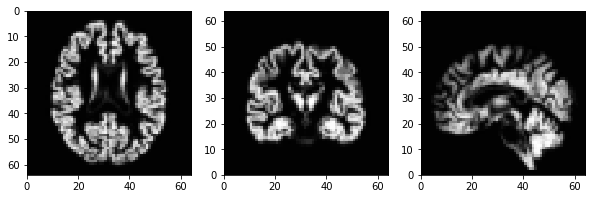

In [0]:
img_size = [64, 64, 64]
img_spacing = [3, 3, 3]

gm_data_train, gm_data_test = preprocess_grey_matter_map()
y_data_train = meta_data_reg_train['age'].values.reshape(-1,1)
y_data_test = meta_data_reg_test['age'].values.reshape(-1,1)

print(img_size)
print(gm_data_train.shape)
print(y_data_train.shape)
print(gm_data_test.shape)
print(y_data_test.shape)

# Visualize pre-processing
display_image(sitk.GetImageFromArray(gm_data_train[0]))

### TASK B-2: Dimensionality reduction

Implement dimensionality reduction for grey matter maps using [scitkit-learn's PCA](http://scikit-learn.org/stable/modules/decomposition.html#pca). PCA has an option to set the percentage of variance to be preserved (by setting the parameter `n_components` to a value between 0 and 1). The number of principal modes, that is the new dimensionality of the data, is then automatically determined. Try initially to preserve 95% of the variance (`n_components=0.95`).

*Note:* When dimensionality reduction is used as pre-processing step for supervised learning, as in this case, it is important that PCA is fitted to the training data only, but then applied to both the training and testing data. So make sure your implementation consists of two separate steps, 1) fitting the PCA model to $X_{\text{train}}$ (using the `fit` function), and 2) applying dimensionality reduction to $X_{\text{train}}$ and $X_{\text{test}}$ using the `transform` function.

In [0]:
########################################
# ADD YOUR CODE HERE
########################################
pca = PCA(n_components=0.95)
gm_data_train_transformed = pca.fit_transform(gm_data_train.reshape(len(gm_data_train), -1))
gm_data_test_transformed = pca.transform(gm_data_test.reshape(len(gm_data_test), -1))
print('PCA result:', gm_data_train_transformed.shape)

PCA result: (500, 443)


### TASK B-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) in the same way as for your approach in Part A so results can be directly compared. Generate the similar plots.

Try using at least three different regression methods.

*Hint:* Remember, when you use cross-validation where you swap training and testing sets in each fold, you need to fit PCA to the training set of each fold.

Fold 1
Linear Regression: mae= 5.5 , r2= 0.86
Lasso Regression: mae= 7.4 , r2 = 0.75
K Neighbors Regression: mae= 7.85 , r2 = 0.72
Bayesian Ridge Regression: mae = 5.78 , r2 = 0.85

Fold 2
Linear Regression: mae= 5.82 , r2= 0.85
Lasso Regression: mae= 7.03 , r2 = 0.79
K Neighbors Regression: mae= 7.06 , r2 = 0.78
Bayesian Ridge Regression: mae = 5.88 , r2 = 0.85

Test result:
Linear Regression: mae = 5.77 , r2 = 0.87
Lasso Regression: mae = 7.17 , r2 = 0.79
K Neighbors Regression: mae = 7.5 , r2 = 0.78
Bayesian Ridge Regression: mae = 6.07 , r2 = 0.86


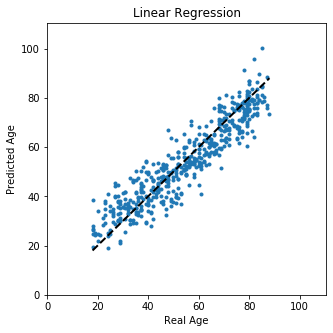

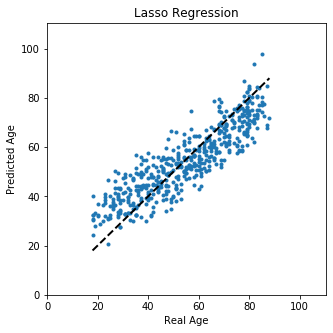

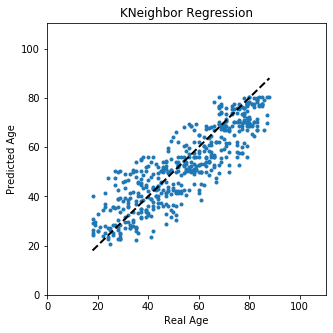

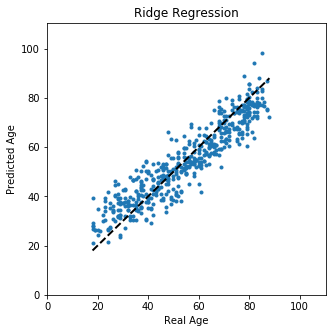

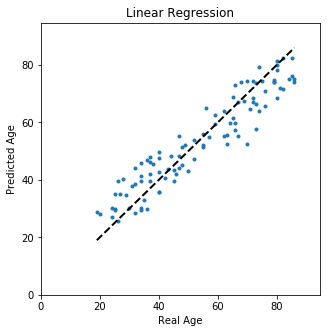

In [0]:
########################################
# ADD YOUR CODE HERE
########################################
k = 2
kf = KFold(n_splits=k, shuffle=True, random_state=rnd_seed)

X_test = gm_data_test.reshape(len(gm_data_test), -1)

lr_preds = []
ll_preds = []
knn_preds = []
ridge_preds = []
y_vals = []

lr_test_mae = []
ll_test_mae = []
knn_test_mae = []
ridge_test_mae = []

lr_test_r2 = []
ll_test_r2 = []
knn_test_r2 = []
ridge_test_r2 = []

for i, (train_index, val_index) in enumerate(kf.split(gm_data_train)):
    print('Fold', i + 1)

    # Load data and reshape
    X_train = gm_data_train[train_index].reshape(len(train_index), -1)
    X_val = gm_data_train[val_index].reshape(len(val_index), -1)
    y_train = y_data_train[train_index].ravel()
    y_val = y_data_train[val_index].ravel()
    y_vals.append(y_val)
    y_test = y_data_test.ravel()

    # PCA
    pca = PCA(n_components = 0.95, random_state=rnd_seed) # 0.95
    X_train_transformed = pca.fit_transform(X_train)
    X_val_transformed = pca.transform(X_val)
    X_test_transformed = pca.transform(X_test)

    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train_transformed, y_train)
    lr_pred = lr.predict(X_val_transformed)
    lr_preds.append(lr_pred)
    lr_mae = np.round(mean_absolute_error(y_val, lr_pred), 2)
    lr_r2 = np.round(r2_score(y_val, lr_pred), 2)
    print('Linear Regression: mae=', lr_mae, ', r2=', lr_r2)
    
    # Lasso Regression
    ll = LassoLars(alpha=0.1)
    ll.fit(X_train_transformed, y_train)
    ll_pred = ll.predict(X_val_transformed)
    ll_preds.append(ll_pred)
    ll_mae = np.round(mean_absolute_error(y_val, ll_pred), 2)
    ll_r2 = np.round(r2_score(y_val, ll_pred), 2)
    print('Lasso Regression: mae=', ll_mae, ', r2 =', ll_r2)
    
    # KNN Regression
    knn = KNeighborsRegressor(n_neighbors=4, algorithm='auto')
    knn.fit(X_train_transformed, y_train)
    knn_pred = knn.predict(X_val_transformed)
    knn_preds.append(knn_pred)
    knn_mae = np.round(mean_absolute_error(y_val, knn_pred), 2)
    knn_r2 = np.round(r2_score(y_val, knn_pred), 2)
    print('K Neighbors Regression: mae=', knn_mae, ', r2 =', knn_r2)

    # Bayesian Ridge Regression
    br = BayesianRidge(normalize=True)
    br.fit(X_train_transformed, y_train)
    ridge_pred = br.predict(X_val_transformed)
    ridge_preds.append(ridge_pred)
    ridge_mae = np.round(mean_absolute_error(y_val, ridge_pred), 2)
    ridge_r2 = np.round(r2_score(y_val, ridge_pred), 2)
    print('Bayesian Ridge Regression: mae =', ridge_mae, ', r2 =', ridge_r2)
    
    # Testing with 100 samples
    lr_test = lr.predict(X_test_transformed)
    lr_test_mae.append(mean_absolute_error(y_test, lr_test))
    lr_test_r2.append(r2_score(y_test, lr_test))

    ll_test = ll.predict(X_test_transformed)
    ll_test_mae.append(mean_absolute_error(y_test, ll_test))
    ll_test_r2.append(r2_score(y_test, ll_test))

    knn_test = knn.predict(X_test_transformed)
    knn_test_mae.append(mean_absolute_error(y_test, knn_test))
    knn_test_r2.append(r2_score(y_test, knn_test))

    ridge_test = br.predict(X_test_transformed)
    ridge_test_mae.append(mean_absolute_error(y_test, ridge_test))
    ridge_test_r2.append(r2_score(y_test, ridge_test))

    print()

print('Test result:')

print('Linear Regression: mae =', np.round(np.average(lr_test_mae), 2), 
      ', r2 =', np.round(np.average(lr_test_r2), 2))
print('Lasso Regression: mae =', np.round(np.average(ll_test_mae), 2), 
      ', r2 =', np.round(np.average(ll_test_r2), 2))
print('K Neighbors Regression: mae =', np.round(np.average(knn_test_mae), 2), 
      ', r2 =', np.round(np.average(knn_test_r2), 2))
print('Bayesian Ridge Regression: mae =', np.round(np.average(ridge_test_mae), 2), 
      ', r2 =', np.round(np.average(ridge_test_r2), 2))

display_pred([lr_preds, ll_preds, knn_preds, ridge_preds], y_vals, 
             info=['Linear Regression', 'Lasso Regression', 
                   'KNeighbor Regression', 'Ridge Regression'])

display_pred(lr_test, y_test, info='Linear Regression')

## Part C: CNN-based regression using grey matter maps

The third approach is similar in nature to the second approach in task B, but instead of using PCA for dimensionality reduction in order to use a more classical regression model, now we will use convolutional neural networks (CNNs) on the grey matter maps for predicting the subject's age directly.

You will need to implement a CNN model that takes a grey matter map as an input and maps it to a one-dimensional, real-valued output. A good starting point may be a LeNet-type architecture and adapt the last layers to convert the classification into a regression network. You should have all the necessary ingredients now from above tasks and the notebooks from the lab tutorials for how to set up a CNN model in PyTorch, how to implement a suitable training and testing routine, and how to run a two-fold cross-validation on the 500 subjects similar to tasks A and B.

*Note:* For part C, only the spatially normalised grey matter maps should be used. Similar to task A, you may want to set up a configuration for the CNN training that may also involve some resampling of the input data.

In [0]:
img_size = [64, 64, 64]
img_spacing = [1, 1, 1]

gm_data_train, gm_data_test = preprocess_grey_matter_map()
y_data_train = meta_data_reg_train['age'].values.reshape(-1,1)
y_data_test = meta_data_reg_test['age'].values.reshape(-1,1)

print(img_size)
print(gm_data_train.shape)
print(y_data_train.shape)
print(gm_data_test.shape)
print(y_data_test.shape)

# Visualize pre-processing
# display_image(sitk.GetImageFromArray(gm_data_train[0]))

Loading and pre-processing training images
Loaded [ 0 / 500 ] images
Loaded [ 100 / 500 ] images
Loaded [ 200 / 500 ] images
Loaded [ 300 / 500 ] images
Loaded [ 400 / 500 ] images
Loading and pre-processing testing images
Loaded [ 0 / 100 ] images
Finished loading
[64, 64, 64]
(500, 64, 64, 64)
(500, 1)
(100, 64, 64, 64)
(100, 1)


In [0]:
batch_size = 20

gm_data_train_expanded = np.expand_dims(gm_data_train, 1)
gm_data_test_expanded = np.expand_dims(gm_data_test, 1)
print(gm_data_train_expanded.shape)
print(gm_data_test_expanded.shape)
dataset_X_train = TensorDataset(torch.Tensor(gm_data_train_expanded), torch.Tensor(y_data_train))
loader_X_train = DataLoader(dataset_X_train, batch_size=batch_size, shuffle=True)
dataset_X_test = TensorDataset(torch.Tensor(gm_data_test_expanded), torch.Tensor(y_data_test))
loader_X_test = DataLoader(dataset_X_test, batch_size=len(gm_data_test), shuffle=False)

(500, 1, 64, 64, 64)
(100, 1, 64, 64, 64)


In [0]:
class CNN3D(nn.Module):
    def __init__(self):
        super(CNN3D, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv3d(1, 4, kernel_size=5, stride=1, padding=1, bias=True), nn.BatchNorm3d(4), nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv3d(4, 8, kernel_size=5, stride=1, padding=1, bias=True), nn.BatchNorm3d(8), nn.ReLU())
        self.conv3 = nn.Sequential(nn.Conv3d(8, 16, kernel_size=5, stride=1, padding=1, bias=True), nn.BatchNorm3d(16), nn.ReLU())
        self.conv4 = nn.Sequential(nn.Conv3d(16, 32, kernel_size=5, stride=1, padding=1, bias=True), nn.BatchNorm3d(32), nn.ReLU())
        self.conv5 = nn.Sequential(nn.Conv3d(32, 64, kernel_size=5, stride=1, padding=1, bias=True), nn.BatchNorm3d(64), nn.ReLU())
        self.conv6 = nn.Sequential(nn.Conv3d(64, 128, kernel_size=5, stride=1, padding=1, bias=True), nn.BatchNorm3d(128), nn.ReLU())
        self.pool = nn.MaxPool3d(2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(p=0.5)
        for m in self.modules():
          if isinstance(m, (nn.Conv3d,nn.Linear)):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
          elif isinstance(m, (nn.BatchNorm3d, nn.GroupNorm)):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

    def forward(self,x):
        x = self.pool(self.conv2(self.conv1(x)))
        x = self.pool(self.conv4(self.conv3(x)))
        x = self.pool(self.conv6(self.conv5(x)))


        # print(x.shape)
        x = x.view(-1, 128 * 4 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

In [0]:
########################################
# ADD YOUR CODE HERE
########################################
class CNN3D(nn.Module):
    def __init__(self):
        super(CNN3D, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv3d(1, 4, kernel_size = 5, stride = 2,padding = 1, bias = False), nn.BatchNorm3d(4), nn.ReLU())
        self.pool1=nn.MaxPool3d(2,stride=2)
        self.conv2 = nn.Sequential(nn.Conv3d(4, 8, kernel_size = 5, stride = 1,padding = 1, bias = False), nn.BatchNorm3d(8), nn.ReLU())
        self.pool2=nn.MaxPool3d(2,stride=2)        
        self.conv3 = nn.Sequential(nn.Conv3d(8, 16, kernel_size = 5, stride = 1,padding = 1, bias = False), nn.BatchNorm3d(16), nn.ReLU())
        self.pool3=nn.MaxPool3d(2,stride=2)
        # # input shape:（45,54,45）
        # self.fc1=nn.Linear(32*2*3*2,512)
        #input shape: (90,108,90)
        #self.fc1=nn.Linear(16*4*4*4,512)
        # #input shape: (64,64,64)
        self.fc1=nn.Linear(16*2*2*2,64)
        self.fc2 = nn.Linear(64,4)
        self.fc3=nn.Linear(4,1)
        for m in self.modules():
          if isinstance(m, (nn.Conv3d,nn.Linear)):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
          elif isinstance(m, (nn.BatchNorm3d, nn.GroupNorm)):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

    def forward(self,x):
        #print(x.shape)
        x=self.pool1((self.conv1(x)))
        #print(x.shape)
        x=self.pool2((self.conv2(x)))
        #print(x.shape)
        x=self.pool3((self.conv3(x)))
        #print(x.shape)
        #input shape:(90,108,90)
        x=x.view(-1,16*2*2*2)
        # input shape:(45,54,45)
        #x =x.view(-1,32*2*3*2)
        # input shape:(64,64,64)
        # x =x.view(-1,16*8)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [0]:
USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print_every = 10
def check_accuracy(model, loader, labels, plot=False):
    # model = model.to(device=device)  # move the model parameters to CPU/GPU
    model.eval()  # set model to evaluation mode
    test_loss = 0
    with torch.no_grad():
        for _, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.float)
            preds = model(x)
            loss = loss_f(preds, y)
            test_loss += loss.item()
            y_preds = preds.cpu().numpy()
        test_loss /= len(loader.dataset)
        mae = mean_absolute_error(labels, y_preds)
        r2 = r2_score(labels, y_preds)
        print('Test loss: {:.3f}, MAE: {:.3f}, r2: {:.3f}'.format(test_loss, mae, r2))

        if plot:
            display_pred(y_preds, labels, info='Test Result')

    return y_preds, test_loss, mae, r2

def train_part(model, loader, optimizer, loss_f, epochs=20, loader_test=None, test_labels=None):
    # model = model.to(device=device)  # move the model parameters to CPU/GPU
    model.train()
    train_losses = []
    test_losses = []
    test_maes = []
    for i in range(epochs):
        train_loss = 0
        for _, (x, y) in enumerate(loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float)
            preds = model(x)
            loss = loss_f(preds, y)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss /= len(loader.dataset)
        train_losses.append(train_loss)
        print('Epoch [{}/{}], train loss: {:.3f}'.format(i + 1, epochs, train_loss))
        if loader_test is not None:
            if test_labels is None:
                test_labels = y_data_test
            y_preds, test_loss, test_mae, test_r2 = check_accuracy(model, loader_test, test_labels)
            test_losses.append(test_loss)
            test_maes.append(test_mae)
    
    if loader_test is not None:
        print('=======================================')
        print('Final Test Result')
        y_preds, test_loss, test_mae, test_r2 = check_accuracy(model, loader_test, 
                                                               test_labels, plot=True)

        plt.figure(figsize=(5, 5))
        plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
        plt.plot(range(len(test_losses)), test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.ylim(0, 5)
        plt.legend()
        plt.title('Train and Test Loss vs. Epoch')

        plt.figure(figsize=(5, 5))
        plt.plot(test_maes)
        plt.xlabel('Epoch')
        plt.ylabel('Test MAE')
        plt.title('Test MAE vs. Epoch')
        plt.show()
        
        return test_loss, test_mae, test_r2

### Train and test model

In [0]:
torch.cuda.empty_cache()
!nvidia-smi

Sun Mar  1 17:41:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Epoch [1/100], train loss: 11.464
Test loss: 2.727, MAE: 13.918, r2: 0.279
Epoch [2/100], train loss: 5.707
Test loss: 0.788, MAE: 7.014, r2: 0.792
Epoch [3/100], train loss: 3.462
Test loss: 0.692, MAE: 6.821, r2: 0.817
Epoch [4/100], train loss: 2.684
Test loss: 0.699, MAE: 6.647, r2: 0.815
Epoch [5/100], train loss: 1.962
Test loss: 0.970, MAE: 8.036, r2: 0.743
Epoch [6/100], train loss: 1.743
Test loss: 0.524, MAE: 5.901, r2: 0.861
Epoch [7/100], train loss: 1.361
Test loss: 0.538, MAE: 5.991, r2: 0.858
Epoch [8/100], train loss: 1.443
Test loss: 0.733, MAE: 6.891, r2: 0.806
Epoch [9/100], train loss: 0.989
Test loss: 0.793, MAE: 7.058, r2: 0.790
Epoch [10/100], train loss: 0.998
Test loss: 0.603, MAE: 6.364, r2: 0.841
Epoch [11/100], train loss: 0.525
Test loss: 0.557, MAE: 6.228, r2: 0.853
Epoch [12/100], train loss: 0.534
Test loss: 0.641, MAE: 6.437, r2: 0.831
Epoch [13/100], train loss: 0.326
Test loss: 0.536, MAE: 6.183, r2: 0.858
Epoch [14/100], train loss: 0.260
Test loss: 

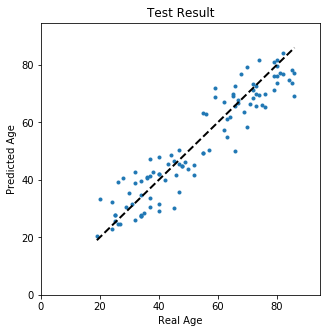

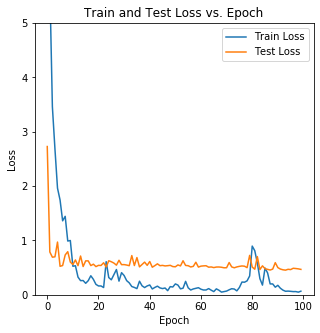

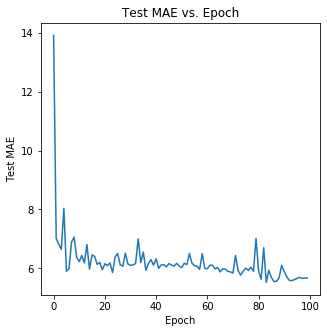

In [0]:
# define and train the network
model = CNN3D()
model = model.to(device=device)
loss_f = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
epoch = 100
_, _, _ = train_part(model, loader_X_train, optimizer, loss_f, 
                     epoch, loader_X_test, y_data_test)

# save the model
torch.save(model.state_dict(), 'model.pt')

###Cross-validation and plot best regression result

Fold  1
Epoch [1/100], train loss: 47.917
Test loss: 5.089, MAE: 31.204, r2: -2.671
Epoch [2/100], train loss: 7.936
Test loss: 2.232, MAE: 20.906, r2: -0.610
Epoch [3/100], train loss: 6.861
Test loss: 0.587, MAE: 10.130, r2: 0.577
Epoch [4/100], train loss: 5.259
Test loss: 0.342, MAE: 7.377, r2: 0.753
Epoch [5/100], train loss: 4.373
Test loss: 0.317, MAE: 7.176, r2: 0.772
Epoch [6/100], train loss: 4.034
Test loss: 0.382, MAE: 8.110, r2: 0.725
Epoch [7/100], train loss: 4.556
Test loss: 0.536, MAE: 9.826, r2: 0.613
Epoch [8/100], train loss: 4.797
Test loss: 0.452, MAE: 8.813, r2: 0.674
Epoch [9/100], train loss: 3.387
Test loss: 0.343, MAE: 7.352, r2: 0.753
Epoch [10/100], train loss: 2.643
Test loss: 0.299, MAE: 7.025, r2: 0.784
Epoch [11/100], train loss: 2.359
Test loss: 0.440, MAE: 8.763, r2: 0.682
Epoch [12/100], train loss: 2.486
Test loss: 0.306, MAE: 7.131, r2: 0.779
Epoch [13/100], train loss: 2.483
Test loss: 0.291, MAE: 6.743, r2: 0.790
Epoch [14/100], train loss: 1.649

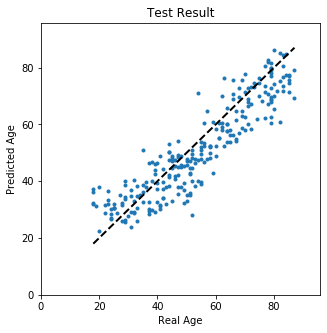

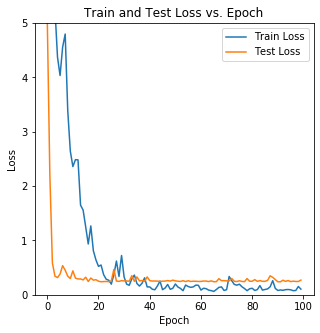

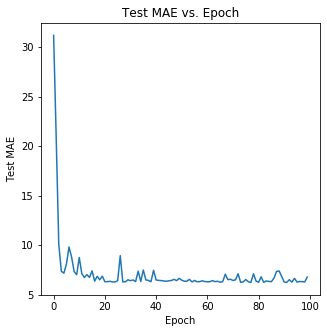

Test loss: 0.270, MAE: 6.787, r2: 0.805
Fold  2
Epoch [1/100], train loss: 20.985
Test loss: 4.778, MAE: 31.133, r2: -2.599
Epoch [2/100], train loss: 8.061
Test loss: 0.850, MAE: 12.414, r2: 0.360
Epoch [3/100], train loss: 5.387
Test loss: 0.452, MAE: 8.173, r2: 0.660
Epoch [4/100], train loss: 4.545
Test loss: 0.399, MAE: 7.636, r2: 0.700
Epoch [5/100], train loss: 4.006
Test loss: 0.474, MAE: 8.738, r2: 0.643
Epoch [6/100], train loss: 4.749
Test loss: 0.393, MAE: 8.028, r2: 0.704
Epoch [7/100], train loss: 3.462
Test loss: 0.342, MAE: 7.217, r2: 0.742
Epoch [8/100], train loss: 2.743
Test loss: 0.313, MAE: 6.750, r2: 0.764
Epoch [9/100], train loss: 2.185
Test loss: 0.287, MAE: 6.515, r2: 0.784
Epoch [10/100], train loss: 2.448
Test loss: 0.269, MAE: 6.361, r2: 0.797
Epoch [11/100], train loss: 2.065
Test loss: 0.290, MAE: 6.857, r2: 0.782
Epoch [12/100], train loss: 1.605
Test loss: 0.264, MAE: 6.300, r2: 0.801
Epoch [13/100], train loss: 1.221
Test loss: 0.244, MAE: 6.202, r2: 0

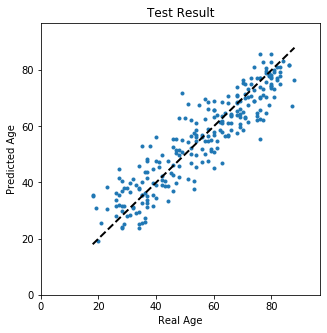

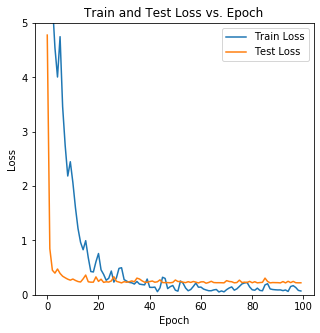

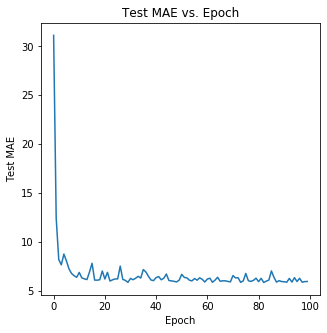

Test loss: 0.221, MAE: 5.930, r2: 0.833
Best result:
Test loss: 0.582, MAE: 6.229, r2: 0.846


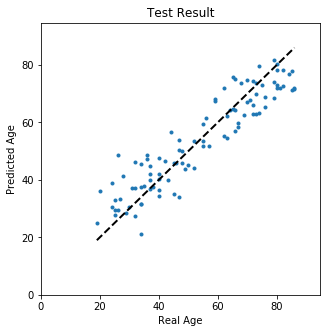

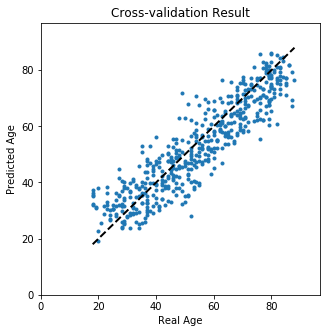

In [0]:
# Cross Validation
kf = KFold(n_splits=2, shuffle=True)
y_preds = []
y_vals = []
best_mae = None
best_r2 = None
best_model = None

loss_f = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
epoch = 100
for i, (train_index, test_index) in enumerate(kf.split(gm_data_train_expanded)):
  print('Fold ', i + 1)
  model = CNN3D().to(device)
  model.train()
  optimizer = torch.optim.Adam(model.parameters())
  X_train, X_val = gm_data_train_expanded[train_index], gm_data_train_expanded[test_index]
  y_train, y_val = y_data_train[train_index], y_data_train[test_index]

  # dataloader
  dataset_X_train_cv = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
  loader_X_train_cv = DataLoader(dataset_X_train_cv, batch_size=batch_size, shuffle=True)
  dataset_X_val_cv = TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val))
  loader_X_val_cv = DataLoader(dataset_X_val_cv, batch_size=250, shuffle=False)

  train_part(model, loader_X_train_cv, optimizer, loss_f, epoch, loader_X_val_cv, y_val)
  pred, val_loss, val_mae, val_r2 = check_accuracy(model, loader_X_val_cv, y_val)
  # y_preds = np.concatenate((y_preds, pred))
  # y_vals = np.concatenate((y_vals, y_val))
  y_preds.append(pred.ravel())
  y_vals.append(y_val.ravel())
  if i == 0 or val_mae < best_mae:
      best_mae = val_mae
      best_r2 = val_r2
      best_model = model

print('=======================================')
print('Best result:')
_, _, _, _ = check_accuracy(best_model, loader_X_test, y_data_test, plot=True)
display_pred(y_preds, y_vals, info='Cross-validation Result')